In [61]:
import numpy as np
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from numpy.random import seed
from sklearn import datasets
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.lda import LDA
from sklearn.metrics import accuracy_score
from itertools import combinations

### Function: Plot decision region


In [62]:
# Defining class for plotting decision regions of a classifier
def plot_decision_regions(X,y,classifier, test_idx=None, resolution=0.02):
    
    #setup marker generator and color map
    markers = ('s','x','o','^','v')
    colors = ('red','blue','green','gray','cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # plot the decision surface
    x1_min,x1_max = X[:,0].min()-1, X[:,0].max()+1
    x2_min,x2_max = X[:,1].min()-1, X[:,1].max()+1
    xx1, xx2 = np.meshgrid(np.arange(x1_min,x1_max,resolution), 
                           np.arange(x2_min, x2_max, resolution))
    #print(xx1.shape)
    #print(xx1.ravel().shape)
    
    Z = classifier.predict(np.array([xx1.ravel(),xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1,xx2,Z,alpha=0.4,cmap=cmap)
    plt.xlim(xx1.min(),xx1.max())
    plt.ylim(xx2.min(),xx2.max())
    
    # plot class samples
    for idx, c1 in enumerate(np.unique(y)):
        plt.scatter(x=X[y==c1,0], y=X[y==c1,1], alpha=0.8, 
                        c=cmap(idx), marker=markers[idx], label=c1)
        
        
    # Highlight test sample
    if test_idx:
        X_test, y_test = X[test_idx,:], y[test_idx]
        plt.scatter(X_test[:,0], X_test[:,1], c='c',alpha=1.0,
                    linewidths=1, marker='o', s=55, label ='test set')

### Wine Dataset

In [63]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 
'Alcalinity of ash', 'Magnesium', 'Total phenols', 
'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 
'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']

#print('Class labels', np.unique(df_wine['Class label']))
#df_wine.head()
# Read the input data 
X,y = df_wine.iloc[:,1:].values,df_wine.iloc[:,0].values
print('The overall dataset is of dimension %d x %d'%(X.shape[0],X.shape[1]))
print('The overall labels is of dimension %d'%(len(y)))

The overall dataset is of dimension 178 x 13
The overall labels is of dimension 178


In [64]:
# Split into train and test
X_train,X_test, y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=0)
print('The training features are of dimension %d x %d'%(X_train.shape[0],X_train.shape[1]))
print('The test features are of dimension %d x %d'%(X_test.shape[0],X_test.shape[1]))
print('The training labels are of dimension %d'%(len(y_train)))
print('The test labels are of dimension %d'%(len(y_test)))

The training features are of dimension 124 x 13
The test features are of dimension 54 x 13
The training labels are of dimension 124
The test labels are of dimension 54


In [65]:
# Standardize the data 
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [66]:
# Compute manually the Eigen values and vectors
cov_mat = np.cov(X_train_std.T)
print('Covariance Matrix of training set is of dimension %d x %d'%(cov_mat.shape[0],cov_mat.shape[0]))

eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
print('\nEigenValues:\n',eigen_vals)

Covariance Matrix of training set is of dimension 13 x 13

EigenValues:
 [ 4.8923083   2.46635032  1.42809973  1.01233462  0.84906459  0.60181514
  0.52251546  0.08414846  0.33051429  0.29595018  0.16831254  0.21432212
  0.2399553 ]


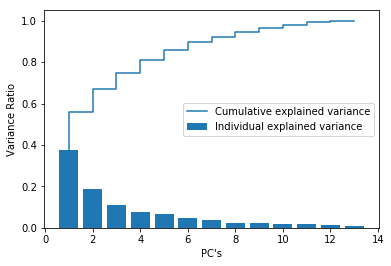

In [67]:
# Look at the variance ratio
tot = sum(eigen_vals)
var_exp = [ (i/tot)  for i in sorted(eigen_vals,reverse=True)  ]
cum_var_exp = np.cumsum(var_exp)

# plot
plt.bar(range(1,14),var_exp,label='Individual explained variance')
plt.step(range(1,14),cum_var_exp,label='Cumulative explained variance')
plt.xlabel("PC's")
plt.ylabel('Variance Ratio')
plt.legend(loc='best')
plt.show()
           

In [68]:
# Feature transform
eigen_pairs = [ (np.abs(eigen_vals[i]),eigen_vecs[:,i])  for i in range(len(eigen_vals))  ]
                 
eigen_pairs.sort(reverse=True)
#print('Sorted Eigen value and vector pair: ', eigen_pairs)

# create transformation matrix w
w = np.hstack( ( eigen_pairs[0][1][:,np.newaxis], eigen_pairs[1][1][:,np.newaxis]  ) )
print ('Transformation matrix W: ',w)

Transformation matrix W:  [[ 0.14669811  0.50417079]
 [-0.24224554  0.24216889]
 [-0.02993442  0.28698484]
 [-0.25519002 -0.06468718]
 [ 0.12079772  0.22995385]
 [ 0.38934455  0.09363991]
 [ 0.42326486  0.01088622]
 [-0.30634956  0.01870216]
 [ 0.30572219  0.03040352]
 [-0.09869191  0.54527081]
 [ 0.30032535 -0.27924322]
 [ 0.36821154 -0.174365  ]
 [ 0.29259713  0.36315461]]


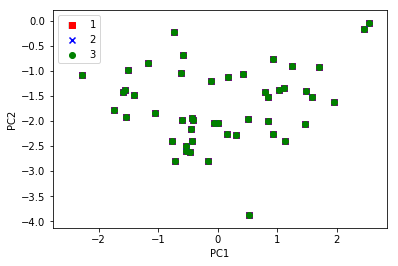

In [69]:
# Transform X into new features
X_train_pca = X_train_std.dot(w)

# Visualize
colors = ['r','b','g']
markers = ['s','x','o']

for l,c,m in zip(np.unique(y_train),colors,markers):
    plt.scatter(X_train_pca[y_train==2,0],X_train_pca[y_train==2,1],c=c,label=l,marker=m)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc='upper left')
plt.show()

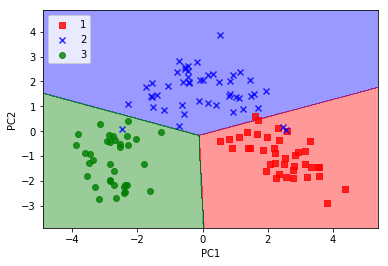

In [70]:
# Using SKLearn's PCA
pca=PCA(n_components=2)
lr = LogisticRegression()

X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test)

lr.fit(X_train_pca,y_train)
plot_decision_regions(X_train_pca,y_train,classifier=lr)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc='upper left')
plt.show()



### LDA

In [71]:
# Compute the mean vector
mean_vecs=[]
for label in range(1,4):
    mean_vecs.append(np.mean(X_train_std[y_train==label],axis=0))
    #print('MV %s: %s\n' %(label, mean_vecs[label-1]))

    
# within class matrix
d = X_train_std.shape[1]

S_W = np.zeros((d,d))

for label, mv in zip(range(1,4),mean_vecs):
    class_scatter=np.cov(X_train_std[y_train==label].T)
    S_W += class_scatter
    
print('Within scatter matrix is of dimension %d x %d'%(S_W.shape[0],S_W.shape[1]))


# Between class matrix

mean_overall = np.mean(X_train_std,axis=0)
S_B = np.zeros((d,d))
for i,mean_vec in enumerate(mean_vecs):
    #print(i, mean_vec)
    n = X_train_std[y_train==i+1,:].shape[0]
    mean_vec = mean_vec.reshape(d,1)
    mean_overall = mean_overall.reshape(d,1)
    #print(mean_vec)
    #print('asdasd',mean_overall)
S_B += n * (mean_vec - mean_overall).dot( (mean_vec - mean_overall).T)
#print(S_B)
print('Between scatter matrix is of dimension %d x %d'%(S_B.shape[0],S_B.shape[1]))


Within scatter matrix is of dimension 13 x 13
Between scatter matrix is of dimension 13 x 13


In [72]:
# Extract the eigen value and vector
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))
#print('Eigen values are: ',np.abs(eigen_vals))

eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i]) for i in range(len(eigen_vals))]
eigen_pairs = sorted(eigen_pairs, key=lambda k:k[0], reverse=True)
print('Eigen values are: ')
#print(eigen_pairs)
for eigen_val in eigen_pairs:
    print(eigen_val[0])

Eigen values are: 
269.799757873
3.5615949798e-14
1.53284647545e-14
1.53284647545e-14
1.40086038509e-14
1.40086038509e-14
1.09131408551e-14
4.7629073649e-15
4.29180642484e-15
5.15722545217e-16
5.15722545217e-16
1.49269022841e-17
0.0


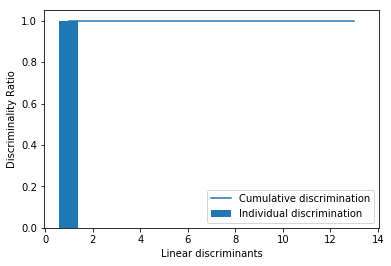

In [73]:
# Look at the discrimination
tot = sum(eigen_vals.real)
discr = [ (i/tot)  for i in sorted(eigen_vals.real,reverse=True)  ]
cum_discr = np.cumsum(discr)

# plot
plt.bar(range(1,14),discr,label='Individual discrimination')
plt.step(range(1,14),cum_discr,label='Cumulative discrimination')
plt.xlabel("Linear discriminants")
plt.ylabel('Discriminality Ratio')
plt.legend(loc='best')
plt.show()

In [74]:
# create transformation matrix w
w = np.hstack( ( eigen_pairs[0][1][:,np.newaxis].real, eigen_pairs[1][1][:,np.newaxis].real  ) )
print ('Transformation matrix W: ',w)

Transformation matrix W:  [[-0.01023192 -0.05652593]
 [-0.08225301 -0.04275096]
 [-0.05458637 -0.00596099]
 [-0.12202041  0.02021277]
 [ 0.00622232 -0.00655573]
 [-0.22569484  0.24445841]
 [ 0.80437516 -0.84646571]
 [ 0.09424097  0.02665877]
 [-0.05082705 -0.03733968]
 [-0.23984071 -0.27565379]
 [ 0.11217038  0.06903919]
 [ 0.39135687  0.36699835]
 [ 0.20623798 -0.02611212]]


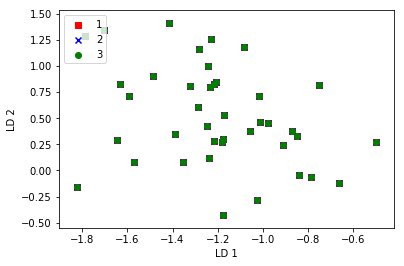

In [75]:
# Projecting new features 
X_train_lda = X_train_std.dot(w)
# Visualize
colors = ['r','b','g']
markers = ['s','x','o']

for l,c,m in zip(np.unique(y_train),colors,markers):
    plt.scatter(X_train_lda[y_train==1,0]*(-1),X_train_lda[y_train==1,1]*(-1),c=c,label=l,marker=m)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='upper left')
plt.show()

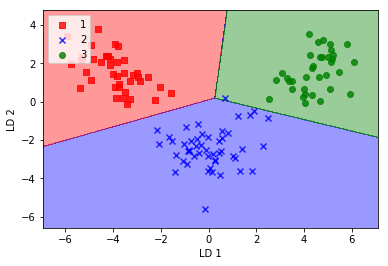

In [76]:
# LDA from scikit learn
lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std,y_train)
lr = LogisticRegression()
lr.fit(X_train_lda,y_train)
plot_decision_regions(X_train_lda,y_train,classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='upper left')
plt.show()